In [9]:
import copy
import sys
import time
import warnings

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
from typing import List

warnings.filterwarnings('ignore')

Parse the Data


In [18]:
from utils import *

problem = 'infinite_slab'
case = 1
study = 6

print("Loading and formating the data...")
t_start = time.time()
if problem == 'infinite_slab':
    dataset = get_data(problem, case, study)
else:
    dataset = get_data(problem, study)
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")

Loading and formating the data...
Loading the data took 13.405113 s


Parameter Definitions

In [19]:
base = "/Users/zacharyhardy/Documents/phd/dissertation/dissertation/figures/"

interior_only = False
test_size = 0.2
seed = 12

tau = 1.0e-8 if problem != 'lra' else 1.0e-10
if problem == 'three_group_sphere':
    interp = 'rbf_gaussian' if study == 0 else 'rbf_cubic'
    epsilon = 5.0 if study == 0 else 200.0
    base += "chapter6/"
elif problem == 'infinite_slab':
    interp = 'rbf_gaussian'
    epsilon = 10.0
    base += "chapter7/"
elif problem == 'twigl':
    interp = 'rbf_gaussian'
    epsilon = 20.0
    base += "chapter8/"
elif problem == 'lra':
    interp = 'rbf_gaussian'
    epsilon = 200.0
    base += "chapter9/"

var = None
if problem != 'three_group_sphere':
    var = 'power_density'

X = dataset.create_dataset_matrix(var)
Y = dataset.parameters

One and Two Snapshot Validation

In [20]:
from pyROMs import POD

try:
    for i in range(1, 3):
        print(f"{i} snapshot validation test...")
        x = np.atleast_2d(X[0:i]).reshape(i, -1)
        y = np.atleast_2d(Y[0:i]).reshape(i, -1)
        pod = POD(svd_rank=-1)
        pod.fit(x, y, interp, epsilon=epsilon)
        x_pod = pod.predict(y)
        one_error = norm(x-x_pod)/norm(x)
        print(f"Error:\t{one_error:.3e}\n")
except BaseException as err:
    print(err.args[0])


1 snapshot validation test...
Error:	1.073e-16

2 snapshot validation test...
Error:	3.448e-16



Construct the ROM

Constructing the ROM...
Construction took 5.276e-02 s
===== POD Summary =====
# of Modes          : 10
# of Snapshots      : 100
Reconstruction Error: 6.489e-05
Mean Snapshot Error : 6.872e-05
Max Snapshot Error  : 1.894e-04
/Users/zacharyhardy/Documents/phd/dissertation/dissertation/figures/chapter7/

Predicting Results with the ROM...
Average prediction time was 1.675e-04 s

===== Summary of 25 POD Queries =====
Number of Snapshots:	100
Number of POD Modes:	10
Average POD Error:	7.491e-05
Maximum POD Error:	1.611e-04
Minimum POD Error:	1.843e-05


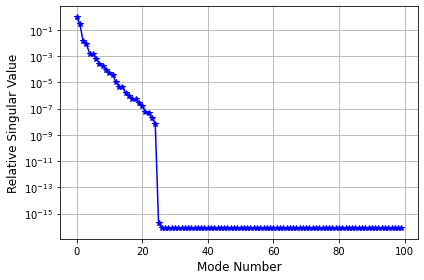

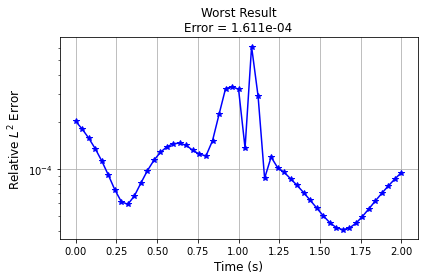

In [21]:
splits = dataset.train_test_split(variables=var,
                                  test_size=test_size, seed=seed,
                                  interior_only=interior_only)
X_train, X_test, Y_train, Y_test = splits

print(f"Constructing the ROM...")
t_start = time.time()
pod = POD(svd_rank=1.0-tau)
pod.fit(X_train, Y_train, interp, epsilon=epsilon)
t_end = time.time()
print(f"Construction took {t_end - t_start:.3e} s")
pod.print_summary()
pod.plot_singular_values()
print(base)
plt.savefig(base + "scree.pdf")

print(f"\nPredicting Results with the ROM...")
t_start = time.time()
X_pod = pod.predict(Y_test)
t_end = time.time()
X_pod = dataset.unstack_simulation_vector(X_pod)
print(f"Average prediction time was {(t_end-t_start)/len(X_pod):.3e} s")

X_test = dataset.unstack_simulation_vector(X_test)
pod_errors = np.zeros(len(X_pod))
for i in range(len(X_pod)):
    pod_errors[i] = norm(X_pod[i]-X_test[i])/norm(X_test[i])

argmax = np.argmax(pod_errors)
x_test, x_pod = X_test[argmax], X_pod[argmax]
pod_step_errors = norm(x_test-x_pod, axis=1)/norm(x_test, axis=1)

start, end = 0, len(x_pod)

plt.figure()
plt.title(f"Worst Result\nError = {pod_errors[argmax]:.3e}")
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Relative $L^2$ Error", fontsize=12)
plt.semilogy(dataset.times[start:end], pod_step_errors[start:end], '-*b')
plt.grid(True)
plt.tight_layout()
# plt.savefig(base + "step_errors.pdf")

msg = f"===== Summary of {len(pod_errors)} POD Queries ====="
header = "=" * len(msg)
print("\n".join(["", header, msg, header]))
print(f"Number of Snapshots:\t{len(X_train)}")
print(f"Number of POD Modes:\t{pod.n_modes}")
print(f"Average POD Error:\t{np.mean(pod_errors):.3e}")
print(f"Maximum POD Error:\t{np.max(pod_errors):.3e}")
print(f"Minimum POD Error:\t{np.min(pod_errors):.3e}")

if problem == 'lra':
    start, end = 120, 160

    # Find peak power arg
    peak_argmax = np.argmax(np.sum(x_pod, axis=1))
    peak_error = norm(x_test[peak_argmax]-x_pod[peak_argmax])
    peak_error /= norm(x_test[peak_argmax])
    print(f"\nError in Peak Power Profile:\t{peak_error:3e}")

    # Plot max power density
    plt.figure()
    P_max_test, P_max_pod = np.max(x_test, axis=1), np.max(x_pod, axis=1)
    plotter = plt.plot
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Power (W)", fontsize=12)
    plotter(dataset.times[start:end], P_max_test[start:end],
                 '-*b', label="Simulation")
    plotter(dataset.times[start:end], P_max_pod[start:end],
            'or', ms=2.5, label="POD")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(base + "pod_vs_simulation.pdf")

    # Plot mean power density
    plt.figure()
    P_mean_test, P_mean_pod = np.mean(x_test, axis=1), np.mean(x_pod, axis=1)
    plotter = plt.semilogy
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Power (W)", fontsize=12)
    plotter(dataset.times[start:end], P_mean_test[start:end],
                 '-*b', label="Simulation")
    plotter(dataset.times[start:end], P_mean_pod[start:end],
            'or', ms=2.5, label="POD")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Plot max power error
    plt.figure()
    error = np.abs(P_max_pod - P_max_test) / P_max_test
    plt.semilogy(dataset.times[start:end], error[start:end], '-*b')
    plt.grid(True)
    plt.tight_layout()

    # Plot mean power error
    plt.figure()
    error = np.abs(P_mean_test - P_mean_pod) / P_mean_test
    plt.semilogy(dataset.times[start:end], error[start:end], '-*b')
    plt.grid(True)
    plt.tight_layout()

Apply DMD to POD Results

Computing DMD of POD Predictions...
Average DMD construction time: 6.597e-03 s

===== Summary of 25 DMD Models =====
Number of Snapshots:	51
Number of DMD Modes:	16
Average DMD Error:	1.586e-04
Maximum DMD Error:	1.163e-03
Minimum DMD Error:	4.325e-05


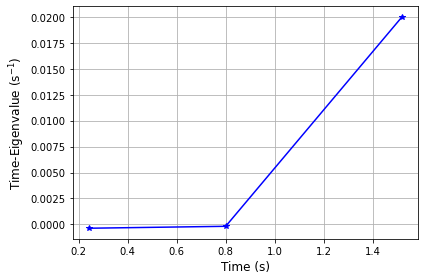

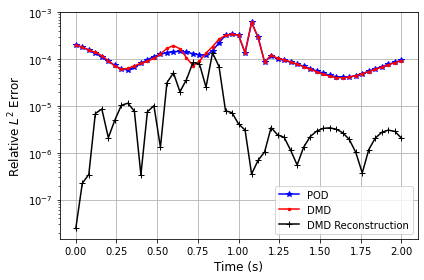

In [22]:
print(f"Computing DMD of POD Predictions...")
dmd_list = []

if problem == 'three_group_sphere':
    from pyROMs import DMD

    t_start = time.time()
    for i in range(len(X_pod)):
        dmd = DMD(svd_rank=tau, opt=True).fit(X_pod[i])
        dmd_list.append(dmd)
    t_end = time.time()

elif problem == 'infinite_slab':
    from pyROMs import DMD, PartitionedDMD

    t_start = time.time()
    for i in range(len(X_pod)):
        dmd = PartitionedDMD(DMD(svd_rank=tau, opt=True), [13, 26])
        dmd_list.append(dmd.fit(X_pod[i]))
    t_end = time.time()

elif problem == 'twigl':
    from pyROMs import DMD, PartitionedDMD

    t_start = time.time()
    for i in range(len(X_pod)):
        dmd = PartitionedDMD(DMD(svd_rank=tau, opt=True), [11, 21])
        dmd_list.append(dmd.fit(X_pod[i]))
    t_end = time.time()

else:
    from pyROMs import DMD, PartitionedDMD

    width = 12
    partitions = np.arange(width, 300, width)
    t_start = time.time()
    for i in range(len(X_pod)):
        dmd = PartitionedDMD(DMD(svd_rank=tau, opt=True), partitions)
        dmd_list.append(dmd.fit(X_pod[i]))
    t_end = time.time()
print(f"Average DMD construction time: {(t_end-t_start)/len(dmd_list):.3e} s")

# Compute errors
dmd_errors = np.zeros(len(dmd_list))
for i in range(len(dmd_list)):
    x_dmd = dmd_list[i].reconstructed_data
    dmd_errors[i] = norm(X_test[i]-x_dmd)/norm(x_dmd)

# Reconstruct worst POD result
x_dmd = dmd_list[argmax].reconstructed_data
dmd_step_errors = norm(x_test-x_dmd, axis=1)/norm(x_test, axis=1)
reconstruction_errors =  dmd_list[argmax].snapshot_errors

times, alphas = [], []
dt = np.diff(dataset.times)[0]
dmd: PartitionedDMD = dmd_list[argmax]
for i, sub_dmd in enumerate(dmd_list[argmax]):
    t = dmd.partial_time_interval(i)
    midpt = t['t0'] + (t['tend']-t['t0'])//2
    times.append(dataset.times[midpt])

    omegas = np.log(sub_dmd.eigvals).real/dt
    idx = np.argsort(sub_dmd.amplitudes.real)[::-1]
    alphas.append(omegas[idx[0]])

plt.figure()
plt.xlabel(f"Time (s)", fontsize=12)
plt.ylabel("Time-Eigenvalue (s$^{-1}$)", fontsize=12)
plt.plot(times, alphas, '-*b')
plt.grid(True)
plt.tight_layout()
plt.savefig(base + "alpha_profile.pdf")

plt.figure()
xlabel = "Time ($\mu$s)" if problem == 'three_group_sphere' else "Time (s)"
plt.xlabel(xlabel, fontsize=12)
plt.ylabel("Relative $L^2$ Error", fontsize=12)
plt.semilogy(dataset.times, pod_step_errors, '-b*', label="POD")
plt.semilogy(dataset.times, dmd_step_errors, '-ro', ms=2.5, label="DMD")
plt.semilogy(dataset.times, reconstruction_errors, '-+k',
             label="DMD Reconstruction")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(base + "pod_dmd_results.pdf")

# Print DMD results
msg = f"===== Summary of {len(pod_errors)} DMD Models ====="
header = "=" * len(msg)
print("\n".join(["", header, msg, header]))
print(f"Number of Snapshots:\t{len(X_pod[0])}")
n_modes = dmd_list[argmax].n_modes
if isinstance(n_modes, list):
    n_modes = sum(n_modes)
print(f"Number of DMD Modes:\t{n_modes}")
print(f"Average DMD Error:\t{np.mean(dmd_errors):.3e}")
print(f"Maximum DMD Error:\t{np.max(dmd_errors):.3e}")
print(f"Minimum DMD Error:\t{np.min(dmd_errors):.3e}")
